# DMRG Test: Block Growth Version

Welcome to the

## Debauch of Indices ##

>"The utility of the absolute differential calculus of Ricci and Levi-Civita must be tempered by an avoidance of excessively formal calculations, where the debauch of indices disguises an often very simple geometric reality. It is this reality that I have sought to reveal."

From the preface of the book *Geometry of Riemannian spaces* by Élie Cartan in 1928.

<Br>

This is a notebook for a simple traditional DMRG algorithm with block growth method. The code shown in this notebook is adapted from Dr. Garrison and Dr. Mishmash from the [simple-dmrg website](https://simple-dmrg.readthedocs.io/en/latest/). This notebook is prepared by Mr. [Song Menghan](https://quantummc.xyz/members/menghan-song/), Mr. [Min Long](https://quantummc.xyz/members/min-long/), Mr. [Shibo Shan](https://quantummc.xyz/members/shibo-shan/) and [ZYM](https://quantummc.xyz/members/ziyang-meng/).

For further information, one can read the reference articles of this notebook by Malvezzi [arXiv:cond-mat/0304375](https://arxiv.org/abs/cond-mat/0304375v1) and by Schollwoeck [arXiv:1008.3477](https://arxiv.org/abs/1008.3477v2).

## 1. Introduction

### 1.1 Background
The core idea behind the DMRG is to find a way in which one can increase the system size without increasing the Hilbert space.

This is typically done in two steps:

$\bullet $ Construct large systems from small systems by gradually increase the system size. So far, the Hilbert space grows exponentially and we have not improved anything.

$\bullet $ Truncate the Hilbert space to a certain value, keeping its size invariant when more sites are added.

Here two key steps one needs to implement:

$\bullet$ How to enlarge the system?

$\bullet$ What is the criterion to truncate the Hilbert space?


### 1.2 Procedure
To start with, we consider a single site which is described by the state $d_i (i=1,...,D)$. Define a block $B(l,m)$ consists of $l$ sites and $H_B$ denotes the Hamiltonion of length $l$ chain. For a Heisenberg chain, $H_B$ is,
$$
H_B = \sum_{\left \langle i,j \right \rangle \in B }\mathbf{S_i}\cdot\mathbf{S_j},
$$
where $B$ is a block containing $l$ sites and $m$ is the dimension of the basis in which we represent the operators of the block (without any truncation, $m=D^{l}$).

The block is then grown by adding a site to it, forming an enlarged block, $B^{e}$. Denote $\left | b_1  \right \rangle ...\left | b_m  \right \rangle $ and $\left | d_1  \right \rangle ...\left | d_D  \right \rangle $ the basis of the block and the additional site, the basis of the enlarged block is their direct product,

$$
\left | b_k^{e}  \right \rangle=\left | b_i  \right \rangle \otimes \left | d_j  \right \rangle,
$$
where $k = 1,2,...,D^{l+1}$, $i = 1,2,...,D^{l}$, $j = 1,...,D$, and thus the dimension of the Hilbert space for $B^{e}$ is the product of that for $B(l,m)$ and a site, $i.e. m\times D = D^{l}\times D = D^{l+1}$.

<img src="https://raw.githubusercontent.com/hylu666/hku-physics4150/main/DMRG_tutorial/block_enlarge.png" width=500 height=400/>


The next step is to form the superblock which consists of two enlarged blocks connected to each other. This sample code considers the open boundary conditions (OBC) and aims to compute the ground state energy of an infinite chain.

For infinite chain algorithm, the superblock is formed by connecting the enlarged block $B_{e}$ and its replica(reflected) $B_{e}^{'}$ together. Compute the Hamiltonian of the superblock and diagonalize it to find its ground state energy and wavefunction,

$$
\left | \Psi_{gs} \right \rangle =\sum_{i=1}^{m\times D}\sum_{j=1}^{m\times D} a_{i,j}\left | b_{i}^{e} \right \rangle\otimes \left | b_j^{'e} \right \rangle,
$$

which is written in a basis that is the tensor product of the system(e.g. left enlarged block) and the environment(e.g. right replica). We can further compute the density matrix of the system,

$$
\rho _{i,i^{'}}=\sum_{j=1}^{m\times D}a_{i,j}a_{i^{'},j}^{*} .
$$

**In statistic mechanics, density matrix tells us which states of the system contribute the most to the above ground state.**

<font color="red"> (Shibo, we need to elaborate a bit more on this point. For example, why $\sum_{a}w_a =1$?)</font>

The density matrix has the same dimension and block-diagonal structure of $H_e$, for the enlarged block. Let's denote $\left | u_{a} \right \rangle, w_{a}(a=1,...,m\times D)$ the eigenvectors and eigenvalues of $\rho$, then $\sum_{a}w_a =1$ with $w_a$ is the probability of the system being in the state $\left | u_{a} \right \rangle$ in the space spanned by the ground state $\left | \Psi_{gs} \right \rangle$.

<br/>

### 1.3 Reduced density matrix
The above analysis guides to keep only the most relevant states to describe the system at the ground states, which reduce the exponentially large Hilbert space into a fixed size. To make an optimal choice, we need to order the state $\left | u_{a} \right \rangle$ by their eigenvalues $w_{a}$ in a decending order and we only use the largest $m$ eigenvectors as a new reduced basis to describe $B_e$. Now the enlarged block is interpreted as $B_e (l+1,m)$ instead of $B_e (l+1,m\times D)$.

Since we adapt a new basis for $B_e$. We need to rotate the operators into the new basis. For example, the Hamiltonian is transformed as,

$$
H_{B(l+1,m)}=OH_{e}O^{\dagger},
$$

where the rows of the $(m,(m\times D))$ matrix $O$ are the selected  $\left | u_{a} \right \rangle$. Again, we clearly see that the Hilbert space size is cut back to $m$.

<img src="https://raw.githubusercontent.com/hylu666/hku-physics4150/main/DMRG_tutorial/truncation.png" width=570 height=250/>

<font color="red"> (see my machine learning lecture, this is exactly the PCA analysis.)</font>

Then we continue add a site to the exsisting block and repeat the routine. We are able to reach a large system size since the Hilbert space size has a ceiling $m$. By monitoring whether the ground state energy of the superblock converges, one can successfully approximate the true ground state and few low-lying states of the system at infinitely large sizes a.k.a. the thermodynamic limit.


## 2. Sample code

In [66]:
from __future__ import print_function, division
import numpy as np
from scipy.sparse import kron, identity
from scipy.sparse.linalg import eigsh  # Lanczos routine from ARPACK
from collections import namedtuple
import matplotlib.pyplot as plt

In [67]:

Block = namedtuple("Block", ("length", "basis_size", "operator_dict"))
EnlargedBlock = namedtuple("EnlargedBlock", ("length", "basis_size", "operator_dict"))

model_d = 2 # single site basis for spin-1/2


In [68]:
def is_valid_block(block):
    for op in block.operator_dict.values():
        if op.shape[0] != block.basis_size or op.shape[1] != block.basis_size:
            return False
    return True
is_valid_enlarged_block = is_valid_block

$ J_+ |j,m\rangle =\sqrt{j(j+1)-m(m+1)}|j,m+1\rangle$

$ J_{-} |j,m\rangle = \sqrt{j(j+1)-m(m-1)}|j,m-1\rangle$

In [69]:
def GetSpinOp(spin):
    '''
    Given a spin quantum number
    return various spin operators and one site H
    '''
    Jp = lambda j,m: np.sqrt(j*(j+1)-m*(m+1))
    Jm = lambda j,m: np.sqrt(j*(j+1)-m*(m-1))

    Mdim = int(2*spin+1)

    Sz = np.zeros((Mdim,Mdim))
    Sp = np.zeros((Mdim,Mdim))
    Sm = np.zeros((Mdim,Mdim))

    for ii in range(Mdim):
        sm = spin-ii
        Sz[ii,ii]= sm
        if ii > 0:
            Sp[ii-1,ii]=Jp(spin,sm)
        if ii < 2*spin:
            Sm[ii+1,ii]=Jm(spin,sm)
    Sx = (Sp+Sm)/2
    Sy = (Sp-Sm)/(2j)

    H1 = np.zeros((Mdim,Mdim))

    return Sz,Sp,Sm,H1

Note that for $s=1/2$, we have

$$S_z= \begin{bmatrix}
 \frac{1}{2} & 0 \\
 0 & -\frac{1}{2}
\end{bmatrix},
S^+ = S_x + i S_y =\begin{bmatrix}
 0 & 1 \\
 0 & 0
\end{bmatrix},
S^-=S_x - i S_y =\begin{bmatrix}
 0 & 0 \\
 1 & 0
\end{bmatrix}, $$

and for $s=1$, we have

$$S_z= \begin{bmatrix}
 1 & 0 & 0 \\
 0 & 0 & 0 \\
 0 & 0 & -1
\end{bmatrix},
S^+ = S_x + i S_y =\begin{bmatrix}
 0 & \sqrt{2} & 0 \\
 0 & 0 & \sqrt{2} \\
 0 & 0 & 0
\end{bmatrix},
S^-=S_x - i S_y =\begin{bmatrix}
 0 & 0 & 0 \\
 \sqrt{2} & 0 & 0 \\
 0 & \sqrt{2} & 0
\end{bmatrix}. $$

<font color="red"> Why don't you check even higher spins, such as $s=3/2$ and $s=2$ ?</font>

In [70]:
Sz1,Sp1,Sm1,H1 = GetSpinOp(1/2)
Sz1,Sp1,Sm1,H1

(array([[ 0.5,  0. ],
        [ 0. , -0.5]]),
 array([[0., 1.],
        [0., 0.]]),
 array([[0., 0.],
        [1., 0.]]),
 array([[0., 0.],
        [0., 0.]]))

Adding a site to the block, compute the enlarged H as follows:
$$
H_e=H_B\otimes I_d+\frac{J}{2}(S_b^{+}\otimes S_d^{-}+S_b^{-}\otimes S_d^{+})+J_z S_b^{z}\otimes S_d^{z},
$$

considering the internal block part and the interaction part with a new spin.

Remember, to calculate the Kronecker product $\mathbf{A} \otimes \mathbf{B}$, is to multiply every element in matrix $\mathbf{A}$ by the entire matrix $\mathbf{B}$.

In [71]:
def H2(Sz1, Sp1, Sz2, Sp2):  # two-site part of the enlarged H
    """
    Given the operators S^z and S^+ on two sites in different Hilbert spaces
    (e.g. two blocks), returns a Kronecker product representing the
    corresponding two-site term in the Hamiltonian that joins the two sites.
    """
    J = Jz = 1.
    TwoSiteH = (J/2)*(kron(Sp1,Sp2.conjugate().transpose())+kron(Sp1.conjugate().transpose(),Sp2))\
    +Jz*kron(Sz1, Sz2)

    return TwoSiteH


In [72]:
initial_block = Block(length=1, basis_size=model_d, operator_dict={
    "H": H1,
    "conn_Sz": Sz1,
    "conn_Sp": Sp1,})

# conn refers to the connection operator, that is, connecting the operator on the edge of
# the block and that on the interior of the chain.  We need to be able to represent S^z
# and S^+ on that site in the current basis in order to grow the chain.

In [73]:
initial_block

Block(length=1, basis_size=2, operator_dict={'H': array([[0., 0.],
       [0., 0.]]), 'conn_Sz': array([[ 0.5,  0. ],
       [ 0. , -0.5]]), 'conn_Sp': array([[0., 1.],
       [0., 0.]])})

Together with the Block Hamiltonian $H_b$, we need to present the spin operators of the rightmost site of the $\mathbf{enlarged}$ block in the basis of the enlarged block (basis with one more site added). For example, the spin-1/2 $S_z$ transforms as:
$$
(S_r^{z})_e = I_b\otimes S_d^{z}=I_b\otimes \begin{bmatrix}
 \frac{1}{2} & 0 \\
 0 & -\frac{1}{2}
\end{bmatrix},
$$
where $I_b$ is the identity matrix of the block Hilbert space, $S_d^{z}$ is the $S_z$ operator for the righmost site.

In [74]:
def enlarge_block(block):
    """
    Enlarges the block by adding one site
    Return the Enlarged block
    """
    mblock = block.basis_size
    o = block.operator_dict

    # Create the new operators for the enlarged block.  Our basis becomes a
    # Kronecker product of the Block basis and the single-site basis.  NOTE:
    # `kron` uses the tensor product convention making blocks of the second
    # array scaled by the first.  As such, we adopt this convention for
    # Kronecker products throughout the code.
    enlarged_operator_dict = {
        "H": kron(o["H"], identity(model_d)) + kron(identity(mblock), H1) + H2(o["conn_Sz"], o["conn_Sp"], Sz1, Sp1),
        "conn_Sz": kron(identity(mblock), Sz1),
        "conn_Sp": kron(identity(mblock), Sp1),
    }

    return EnlargedBlock(length=(block.length + 1),
                         basis_size=(block.basis_size * model_d),
                         operator_dict=enlarged_operator_dict)

In [75]:
def ChangeBasis(operator,trans_mat):
    '''
    Transform the operator into the truncated basis with trans_mat
    '''
    op_new = trans_mat.conjugate().transpose().dot(operator.dot(trans_mat))
    return op_new


Here we define a single DMRG step with one site added.

Note that the formation of the superblock Hamiltonian is similar to that for $H_e$. They both consist three parts: Hamiltonian for both enlarged block (in the construction for $H_e$, one can regard the additional site as a right block with a single site Hamiltonion which is zero) and the interaction between the connecting sites.

$$
H_s=H_e\otimes I_e^{'}+I_e \otimes H_e^{'}+\frac{J}{2}\{(S_r^{+})_e \otimes (S_r^{-})_{e}^{'}+(S_r^{-})_e\otimes (S_r^{+})_e^{'}\}+J_z (S_r^{z})_e\otimes (S_r^{z})_e^{'},
$$

where the subscript $r$ means the rightmost site of the block, and $'$ stands for the replica enlarged block.

We sum up the eigenvalues of the discarded eigenstates $(1-\sum_{a=1}^{m}w_a)$ as the measure for the truncation error. In many cases, this number is roughly proportional to the error in the energy.

<font color="red"> what is the meaning of this line below "psi0 = psi0[:,0].reshape([sys_enl.basis_size, -1], order="C") #gs wavefunction" ? Let's demonstrate with an explicit exmaple. </font>

## 5-Site Wavefunction Mapping (3-Site System vs 2-Site Environment)

The command `psi0.reshape([8, -1], order="C")` maps the ground state vector into the following matrix $\Psi_{S,E}$.

In **C-style (row-major) ordering**, the Environment states (columns) change fastest in the underlying memory.

| | Env: $\uparrow\uparrow$ | Env: $\uparrow\downarrow$ | Env: $\downarrow\uparrow$ | Env: $\downarrow\downarrow$ |
| :--- | :---: | :---: | :---: | :---: |
| **Sys: $\uparrow\uparrow\uparrow$** | $\psi_{0}$ | $\psi_{1}$ | $\psi_{2}$ | $\psi_{3}$ |
| **Sys: $\uparrow\uparrow\downarrow$** | $\psi_{4}$ | $\psi_{5}$ | $\psi_{6}$ | $\psi_{7}$ |
| **Sys: $\uparrow\downarrow\uparrow$** | $\psi_{8}$ | $\psi_{9}$ | $\psi_{10}$ | $\psi_{11}$ |
| **Sys: $\uparrow\downarrow\downarrow$** | $\psi_{12}$ | $\psi_{13}$ | $\psi_{14}$ | $\psi_{15}$ |
| **Sys: $\downarrow\uparrow\uparrow$** | $\psi_{16}$ | $\psi_{17}$ | $\psi_{18}$ | $\psi_{19}$ |
| **Sys: $\downarrow\uparrow\downarrow$** | $\psi_{20}$ | $\psi_{21}$ | $\psi_{22}$ | $\psi_{23}$ |
| **Sys: $\downarrow\downarrow\uparrow$** | $\psi_{24}$ | $\psi_{25}$ | $\psi_{26}$ | $\psi_{27}$ |
| **Sys: $\downarrow\downarrow\downarrow$** | $\psi_{28}$ | $\psi_{29}$ | $\psi_{30}$ | $\psi_{31}$ |

**Reduced Density Matrix Calculation:**

$\rho_S = \Psi \Psi^\dagger$ is computed via `np.dot(psi0, psi0.conj().T)`, resulting in an $8 \times 8$ matrix.

From here we can PCA the $\rho_S$ to further reduce the 8 to our desired $mm$.

In [76]:
def cal_renyi(rho,order):
  prob = np.linalg.eig(rho)[0]
  renyi = (1/(1-order))*np.log(np.sum(prob**order))
  return renyi

In [77]:
def single_dmrg_step(sys,env,mm):
    '''
    single DMRG step with the maximum truncation mm, mm states in the new basis
    '''
    # assert is_valid_block(sys)
    # assert is_valid_block(env) #check whether the block is legal

    sys_enl = enlarge_block(sys)

    if sys is env: #if they are same, no need to compute again
        env_enl = sys_enl
    else:
        env_enl = enlarge_block(env)

    # assert is_valid_enlarged_block(sys_enl)
    # assert is_valid_enlarged_block(env_enl) #check whether enl_block is legal

    #construct the superblock Hamiltonian.
    m_sys_enl = sys_enl.basis_size
    m_env_enl = env_enl.basis_size
    sys_enl_op = sys_enl.operator_dict
    env_enl_op = env_enl.operator_dict
    superblock_H = kron(sys_enl_op["H"],identity(m_env_enl))\
                  +kron(identity(m_sys_enl), env_enl_op["H"])\
                  +H2(sys_enl_op["conn_Sz"], sys_enl_op["conn_Sp"], env_enl_op["conn_Sz"], env_enl_op["conn_Sp"])

    #find the superblock ground state.
    #'SA' means find the 'smallest in amplitude' eig_value
    #|psi0> = sigma{i}sigma{j}: a(i,j)|bi>|bj>
    #|bi>, |bj> are the basis of the sys and env
    #rehape the eigenvector such that (row,colum) corresponds to (sys,env)
    #Now, the matrix elements of psi0 are a(i,j)
    #rho is the density matrix
    (energy), psi0 = eigsh(superblock_H, k=6, which="SA")
    psi_g = psi0[:,0]
    print(psi_g[1])
    psi0 = psi0[:,0].reshape([sys_enl.basis_size, -1], order="C") #gs wavefunction

    rho = np.dot(psi0,psi0.conjugate().transpose()) # trace_env
    renyi_entropy = cal_renyi(rho,2)
    print("dimension of the density matrix:", rho.shape)

    evals,evecs = np.linalg.eigh(rho)
    possible_eigenstates = []
    for eig_val, eig_vec in zip(evals, evecs.transpose()):
        possible_eigenstates.append((eig_val, eig_vec))
    possible_eigenstates.sort(reverse=True, key=lambda x: x[0])  # largest eigenvalue first

    eig_rho = []
    for eig_val, _ in possible_eigenstates:
        eig_rho.append(float(eig_val))

    #Based on the truncation 'mm', compute trans_mat
    my_m = min(len(possible_eigenstates),mm)
    trans_mat = np.zeros((sys_enl.basis_size, my_m), dtype='d', order='F')
    for index in range(my_m):
        eigenvalue, eigenvector = possible_eigenstates[index]
        trans_mat[:, index] = eigenvector


    truncation_error = 1 - sum([x[0] for x in possible_eigenstates[:my_m]])
    print("truncation error:", truncation_error)
    #change the basis for each operator
    new_operator_dict={}
    print(f"system H dimmension before truncation: {sys_enl.operator_dict['H'].shape}")
    for name, op in sys_enl.operator_dict.items():
        new_operator_dict[name] = ChangeBasis(op,trans_mat)
    print(f"system H dimmension after truncation: {new_operator_dict['H'].shape}")

    newblock = Block(length=sys_enl.length,
                     basis_size=my_m,
                     operator_dict=new_operator_dict)
    return newblock, energy[0],(energy[1]-energy[0]),(energy[4]-energy[0]),eig_rho, renyi_entropy







In [78]:
(energy,), psi0  = eigsh(Sz1, k=1, which="SA")

In [79]:
energy,psi0

(np.float64(-0.5000000000000001),
 array([[-0.],
        [-1.]]))

### 2.1 Infinite system algorithm

In [ ]:
L_list=[]
gap_half_list=[]

L=64
mm=32
block = initial_block
#keep growing the block
#let the right block = left block, i.e. env=sys
while 2*block.length<L:
    #1st step, grow 1 to 2 sites, hence 4 sites in superblock
    print('L =',block.length*2 + 2)
    L_list.append(block.length*2 + 2)
    block, energy,gap,gap4, eig_rho, renyi_entropy = single_dmrg_step(block, block, mm)
    print('E/L =', energy/(block.length*2))
    print('gap=',gap)
    print("gap4=",gap4)
    gap_half_list.append(gap)
for v in eig_rho:
    print(f"{v:.4e}")

L = 4
-3.2870118914260126e-17
dimension of the density matrix: (4, 4)
truncation error: -1.3322676295501878e-15
system H dimmension before truncation: (4, 4)
system H dimmension after truncation: (4, 4)
E/L = -0.4040063509461098
gap= 0.6589186225978919
gap4= 1.3660254037844388
L = 6
0.6519988293561008
dimension of the density matrix: (8, 8)
truncation error: -1.1102230246251565e-15
system H dimmension before truncation: (8, 8)
system H dimmension after truncation: (8, 8)
E/L = -0.4155961889813211
gap= 0.49158177698938976
gap4= 1.072115592499338
L = 8
0.14373873269907866
dimension of the density matrix: (16, 16)
truncation error: -3.3306690738754696e-15
system H dimmension before truncation: (16, 16)
system H dimmension after truncation: (16, 16)
E/L = -0.4218665748359868
gap= 0.39269211092500056
gap4= 0.8712035293100797
L = 10
0.6315378215906833
dimension of the density matrix: (32, 32)
truncation error: 1.4432899320127035e-15
system H dimmension before truncation: (32, 32)
system H di

In [ ]:
L_rev = 1/np.array(L_list)




### 2.2 Finite system algorithm

In this fintie system algorithm, we aims to simulate the finite chain with length L precisely instead of reaching the thermal dynamic limit. Therefore, we need to grow the block to our required length, fix it and we do sweeps to equilibrate the chain. The overall procedure is listed below:
1. First use the infinite size algorithm until the superblock size reaches the chain size L under investigation. After every truncation save all operators of the reduced block to disk.
2. Denote the length of the system block by $l$. Load the environment block of size $L − l − 2$ from disk, this is the right block.
3. Call single_dmrg_step with inputs sys and env which are save in the disk. Then, the system block's length increases by one, $l\to l+1$.
4. Continue step 2 and 3 untill the environment block becomes a single site.
5. Then reverse the system and the environment, do step 4 untill energy converges.


In [ ]:
def graphic(sys_block, env_block, sys_label="l"):
    """This is a graphic representation of the block,
    =: stands for the system
    -: stands for the environment
    **: stands for the intermedium two sites
    """
    assert sys_label in ("l", "r")
    graphic = ("=" * sys_block.length) + "**" + ("-" * env_block.length)
    if sys_label == "r":
        # The system should be on the right and the environment should be on
        # the left, so reverse the graphic.
        graphic = graphic[::-1]
    return graphic

In [ ]:
def finite_system_algorithm(L, m_warmup, m_sweep_list):
    '''tate energy of the finite system.
    A sweep goes as:
    This function print the process of sweeps and return the ground s
    ====**---- >> ======**-- >> -------**= >> --**====== >> =**------- >> ====**----

    L: system length
    m_warmup: the truncation length used for growing the system to length L
    m_sweep_list: a list contains different 'mm' for consideration.
    '''
    threshold = 1e-4
    assert L % 2 == 0  # require that L is an even number

    # To keep things simple, this dictionary is not actually saved to disk, but
    # we use it to represent persistent storage.
    block_disk = {}  # "disk" storage for Block objects

    # Use the infinite system algorithm to build up to desired size.  Each time
    # we construct a block, we save it for future reference as both a left
    # ("l") and right ("r") block, as the infinite system algorithm assumes the
    # environment is a mirror image of the system.
    block = initial_block
    block_disk["l", block.length] = block
    block_disk["r", block.length] = block
    if_balanced = 0
    while 2 * block.length < L:
        # Perform a single DMRG step and save the new Block to "disk"
        # grow block size to L/2 and now the system is L/2 -2
        print(graphic(block, block))
        block, energy,gap,gap4,eig_rho, renyi_entropy = single_dmrg_step(block, block, mm=m_warmup)
        print("E/L =", energy / (block.length * 2))
        print("gap =",gap)
        #print("gap4 =",gap4)

        block_disk["l", block.length] = block
        block_disk["r", block.length] = block

    # Now that the system is built up to its full size, we perform sweeps using
    # the finite system algorithm.  At first the left block will act as the
    # system, growing at the expense of the right block (the environment), but
    # once we come to the end of the chain these roles will be reversed.
    sys_label, env_label = "l", "r"
    sys_block = block; del block  # rename the variable

    energy = 0
    L_sys = []
    renyi_entropy_list = []
    if_balanced = 0
    for mm in m_sweep_list:
        while True:
            # Load the appropriate environment block from "disk"
            env_block = block_disk[env_label, L - sys_block.length - 2]

            # Perform a single DMRG step.
            print(graphic(sys_block, env_block, sys_label))
            energy_old = energy
            sys_block,energy,gap,gap4,eig_rho, renyi_entropy = single_dmrg_step(sys_block, env_block, mm=mm)
            if if_balanced == 1 and sys_label == 'r':
                L_sys.append(sys_block.length)
                renyi_entropy_list.append(renyi_entropy)
                if sys_block.length == L-2:
                    return L_sys, renyi_entropy_list
            print(sys_block.length)
            print(renyi_entropy)
            print("E/L =", energy / L)
            print("gap =",gap)
            #print("gap4 =",gap4)


            # Save the block from this step to disk.
            block_disk[sys_label, sys_block.length] = sys_block
            if env_block.length == 1:
                # We've come to the end of the chain, so we reverse course.
                sys_block, env_block = env_block, sys_block
                sys_label, env_label = env_label, sys_label



            # Check whether we just completed a full sweep.
            if sys_label == "l" and 2 * sys_block.length == L and np.abs(energy-energy_old) < threshold:
                if_balanced = 1


In [ ]:
L = 16
np.set_printoptions(precision=10, suppress=True, threshold=10000, linewidth=300)
L_list = [16, 32, 48]
L_sys_list = []
renyi_entropy_half_list = []
for L in L_list:
  L_sys,renyi_entropy_half = finite_system_algorithm(L, m_warmup=32, m_sweep_list=[32])
  L_sys_list.append(L_sys)
  renyi_entropy_half_list.append(renyi_entropy_half)


=**-
1.4785729836611262e-16
dimension of the density matrix: (4, 4)
truncation error: 1.1102230246251565e-16
system H dimmension before truncation: (4, 4)
system H dimmension after truncation: (4, 4)
E/L = -0.4040063509461097
gap = 0.6589186225978911
==**--
-0.651998829356101
dimension of the density matrix: (8, 8)
truncation error: -1.1102230246251565e-15
system H dimmension before truncation: (8, 8)
system H dimmension after truncation: (8, 8)
E/L = -0.4155961889813213
gap = 0.49158177698939287
===**---
-0.11840046078178075
dimension of the density matrix: (16, 16)
truncation error: 7.771561172376096e-16
system H dimmension before truncation: (16, 16)
system H dimmension after truncation: (16, 16)
E/L = -0.42186657483598655
gap = 0.39269211092500456
====**----
0.6315378215906843
dimension of the density matrix: (32, 32)
truncation error: -1.9984014443252818e-15
system H dimmension before truncation: (32, 32)
system H dimmension after truncation: (32, 32)
E/L = -0.425803520728289
gap 

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'second order Renyi Entropy')

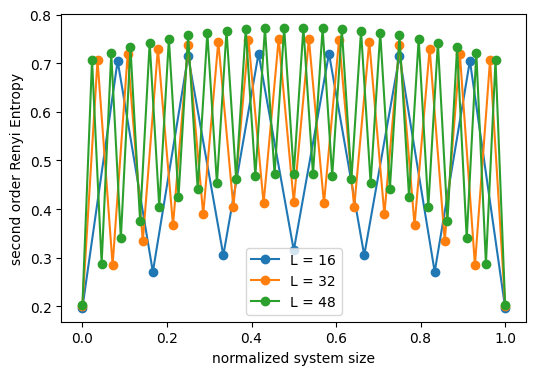

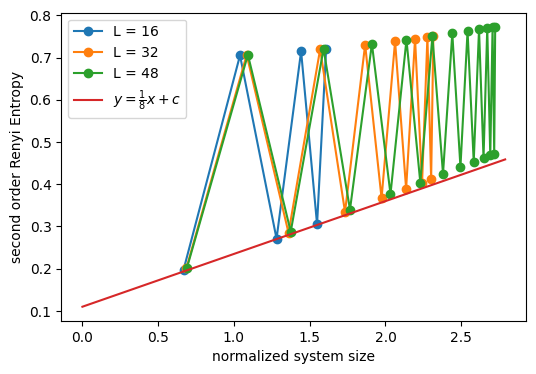

In [ ]:
plt.figure(figsize = (6,4))
for i in range(len(L_list)):
  x = np.array(L_sys_list[i])
  x = (x - x[0]) / (x[-1] - x[0])
  y = renyi_entropy_half_list[i]
  plt.plot(x, y, 'o-', label = f"L = {L_list[i]}")
plt.legend()
plt.xlabel('normalized system size')
plt.ylabel('second order Renyi Entropy')

plt.figure(figsize = (6,4))
for i in range(len(L_list)):
  x = np.array(L_sys_list[i])
  n = len(x) // 2
  x = x[:n]
  x = np.log(L_list[i] / np.pi * np.sin(np.pi / L_list[i] * x))
  y = renyi_entropy_half_list[i]
  y = y[:n]
  plt.plot(x, y, 'o-', label = f"L = {L_list[i]}")
x = np.arange(0,2.8,0.01)
y = 1/8 * x+0.11
plt.plot(x,y, label = r'$y = \frac{1}{8}x + c$')
plt.legend()
plt.xlabel('normalized system size')
plt.ylabel('second order Renyi Entropy')



In [ ]:
print(x)

[0.0454545455 0.0681818182 0.0909090909 0.1136363636 0.1363636364 0.1590909091 0.1818181818 0.2045454545 0.2272727273 0.25         0.2727272727 0.2954545455 0.3181818182 0.3409090909 0.3636363636 0.3863636364 0.4090909091 0.4318181818 0.4545454545 0.4772727273 0.5          0.5227272727 0.5454545455
 0.5681818182 0.5909090909 0.6136363636 0.6363636364 0.6590909091 0.6818181818 0.7045454545 0.7272727273 0.75         0.7727272727 0.7954545455 0.8181818182 0.8409090909 0.8636363636 0.8863636364 0.9090909091 0.9318181818 0.9545454545 0.9772727273 1.           1.0227272727 1.0454545455]


## 3. Benchmark with ED

In [ ]:
def ED_1d(N,OBC=None):
    dimension=2**N
    #spin chain with all spin-down
    z='0'*N
    # initialize hamiltonian
    H=np.zeros((dimension,dimension))
    # Matrix Construction
    for a in range(dimension):
        if OBC==True:
            num=N-1
        else:
            num=N
        for i in range(num): #N-1 if OBC

            j=np.mod(i+1,N)
            state_chain=bin(a)[2:] # the first two should be omitted for this 'bin' function
            l=len(state_chain)
    #        print(state_chain)
            state_chain=z[0:N-l]+state_chain # make the length equal to N
            if state_chain[i]==state_chain[j]: # i=j only diagonal elements
                H[a,a]+=0.25
            else:                              # else, the raising/lowering operators also have contributions
                H[a,a]-=0.25
                # then exchange i,j
                element_i=state_chain[i]
                element_j=state_chain[j]
                #flip
                if max(i,j)==N-1:
                    if i>j:  #here we are doing the concatenation of string (you can try other methods)
                        state_chain=element_i+state_chain[1:N-1]+element_j
    #                    print(state_chain)
                    else:
                        state_chain=state_chain[0:i]+element_j+element_i
    #                    print(state_chain)
                else:
                    state_chain=state_chain[0:i]+element_j+element_i+state_chain[j+1:]
    #            print(state_chain)
                b=int(state_chain,2)
                H[a,b]+=0.5
    eig_value=np.real(np.linalg.eig(H)[0])# eigen_values
    eig_vec=np.real(np.linalg.eig(H)[1])  # eigenstates

    idx_sorted1 = np.argsort(eig_value)
    eig_value=eig_value[idx_sorted1]
    eig_vec=eig_vec[:,idx_sorted1]
    eig_value[0]/N, eig_vec[:,0]
    energy_level=np.sort(eig_value/N)
    #return Ground Energy per site
    return energy_level[0],(energy_level[1]-energy_level[0])*N


In [ ]:
for L in [4,6,8,10]:
    print('L =',L)
    E0,gap = ED_1d(L,OBC=False)
    print('E/L =', E0)
    print("gap =", gap)

L = 4
E/L = -0.49999999999999967
gap = 0.9999999999999984
L = 6
E/L = -0.46712927295533174
gap = 0.6847416489820877
L = 8
E/L = -0.4563866761171472
gap = 0.5226743450925904
L = 10
E/L = -0.45154463544920587
gap = 0.42323900775335765


## 4. Test for spin-1 chain

In [80]:
Block = namedtuple("Block", ["length", "basis_size", "operator_dict"])
EnlargedBlock = namedtuple("EnlargedBlock", ["length", "basis_size", "operator_dict"])

model_d = 3 # single site basis for spin-1.

Sz1,Sp1,Sm1,H1 = GetSpinOp(1)
Sz1,Sp1,Sm1,H1


(array([[ 1.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0., -1.]]),
 array([[0.          , 1.4142135624, 0.          ],
        [0.          , 0.          , 1.4142135624],
        [0.          , 0.          , 0.          ]]),
 array([[0.          , 0.          , 0.          ],
        [1.4142135624, 0.          , 0.          ],
        [0.          , 1.4142135624, 0.          ]]),
 array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]))

In [81]:
initial_block = Block(length=1, basis_size=model_d, operator_dict={
    "H": H1,
    "conn_Sz": Sz1,
    "conn_Sp": Sp1,})

In [ ]:
L_list=[]
gap_one_list=[]

L=64
mm=32
block = initial_block
#keep growing the block
#let the right block = left block, i.e. env=sys
while 2*block.length<L:
    #1st step, grow 1 to 2 sites, hence 4 sites in superblock
    print('L =',block.length*2 + 2)
    L_list.append(block.length*2 + 2)
    block, energy,gap,gap4,eig_rho, renyi_entropy = single_dmrg_step(block, block, mm)
    #print('E/L =', energy/(block.length*2))
    #print('gap=',gap)
    #print("gap4=",gap4)
    gap_one_list.append(gap4)

L = 4
9.661964720057257e-18
dimension of the density matrix: (9, 9)
truncation error: -2.220446049250313e-16
system H dimmension before truncation: (9, 9)
system H dimmension after truncation: (9, 9)
L = 6
-5.575598881174426e-16
dimension of the density matrix: (27, 27)
truncation error: 1.7763568394002505e-15
system H dimmension before truncation: (27, 27)
system H dimmension after truncation: (27, 27)
L = 8
-0.03372375067081774
dimension of the density matrix: (81, 81)
truncation error: 1.3120555641954468e-07
system H dimmension before truncation: (81, 81)
system H dimmension after truncation: (32, 32)
L = 10
3.2341063336544514e-09
dimension of the density matrix: (96, 96)
truncation error: 2.8099453619478965e-07
system H dimmension before truncation: (96, 96)
system H dimmension after truncation: (32, 32)
L = 12
-5.7972564725791125e-08
dimension of the density matrix: (96, 96)
truncation error: 9.756620547030082e-07
system H dimmension before truncation: (96, 96)
system H dimmension

In [82]:
np.set_printoptions(precision=10, suppress=True, threshold=10000, linewidth=300)
L_list = [16, 32, 48]
L_sys_list = []
renyi_entropy_one_list = []
for L in L_list:
  L_sys,renyi_entropy_one = finite_system_algorithm(L, m_warmup=32, m_sweep_list=[32])
  L_sys_list.append(L_sys)
  renyi_entropy_one_list.append(renyi_entropy_one)

=**-
-6.482518671137816e-18
dimension of the density matrix: (9, 9)
truncation error: -1.5543122344752192e-15
system H dimmension before truncation: (9, 9)
system H dimmension after truncation: (9, 9)
E/L = -1.1614378277661477
gap = 0.5091697897160845
==**--
1.144306925895562e-15
dimension of the density matrix: (27, 27)
truncation error: -4.440892098500626e-16
system H dimmension before truncation: (27, 27)
system H dimmension after truncation: (27, 27)
E/L = -1.2283791615707678
gap = 0.30778555865203483
===**---
-0.002655318523583057
dimension of the density matrix: (81, 81)
truncation error: 1.3120555431012093e-07
system H dimmension before truncation: (81, 81)
system H dimmension after truncation: (32, 32)
E/L = -1.265579652794862
gap = 0.2018786740387135
====**----
5.436578122244814e-09
dimension of the density matrix: (96, 96)
truncation error: 2.8088318482222263e-07
system H dimmension before truncation: (96, 96)
system H dimmension after truncation: (32, 32)
E/L = -1.2894554410

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'second order Renyi Entropy')

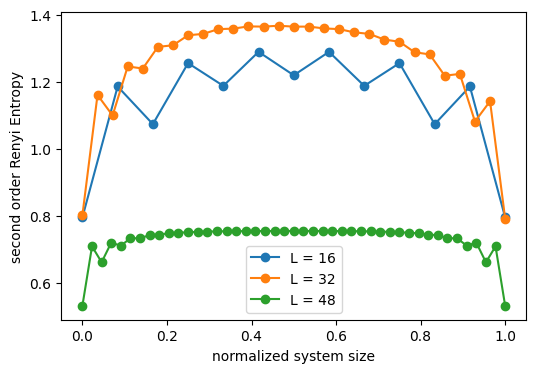

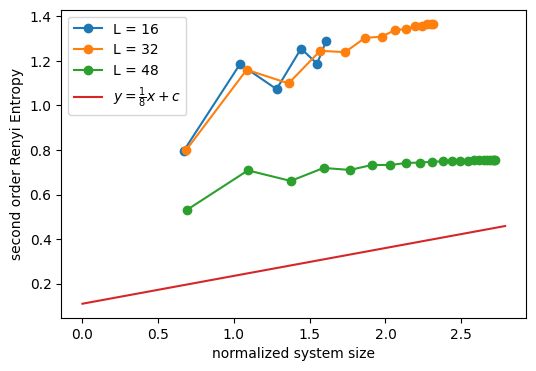

In [83]:
plt.figure(figsize = (6,4))
for i in range(len(L_list)):
  x = np.array(L_sys_list[i])
  x = (x - x[0]) / (x[-1] - x[0])
  y = renyi_entropy_one_list[i]
  plt.plot(x, y, 'o-', label = f"L = {L_list[i]}")
plt.legend()
plt.xlabel('normalized system size')
plt.ylabel('second order Renyi Entropy')

plt.figure(figsize = (6,4))
for i in range(len(L_list)):
  x = np.array(L_sys_list[i])
  n = len(x) // 2
  x = x[:n]
  x = np.log(L_list[i] / np.pi * np.sin(np.pi / L_list[i] * x))
  y = renyi_entropy_one_list[i]
  y = y[:n]
  plt.plot(x, y, 'o-', label = f"L = {L_list[i]}")
x = np.arange(0,2.8,0.01)
y = 1/8 * x+0.11
plt.plot(x,y, label = r'$y = \frac{1}{8}x + c$')
plt.legend()
plt.xlabel('normalized system size')
plt.ylabel('second order Renyi Entropy')


/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'second order Renyi Entropy')

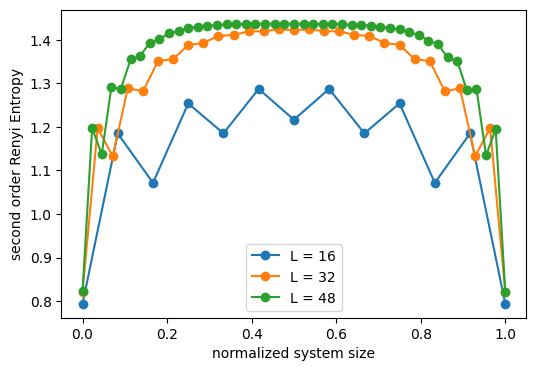

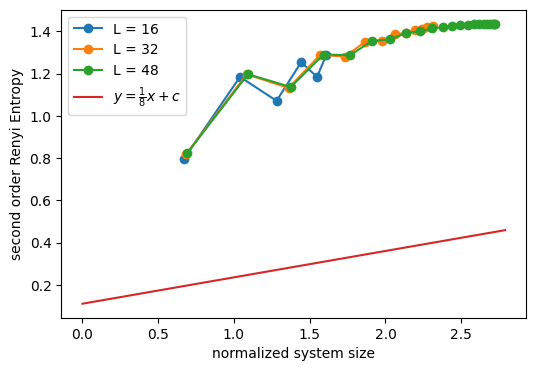

In [ ]:
plt.figure(figsize = (6,4))
for i in range(len(L_list)):
  x = np.array(L_sys_list[i])
  x = (x - x[0]) / (x[-1] - x[0])
  y = renyi_entropy_one_list[i]
  plt.plot(x, y, 'o-', label = f"L = {L_list[i]}")
plt.legend()
plt.xlabel('normalized system size')
plt.ylabel('second order Renyi Entropy')

plt.figure(figsize = (6,4))
for i in range(len(L_list)):
  x = np.array(L_sys_list[i])
  n = len(x) // 2
  x = x[:n]
  x = np.log(L_list[i] / np.pi * np.sin(np.pi / L_list[i] * x))
  y = renyi_entropy_one_list[i]
  y = y[:n]
  plt.plot(x, y, 'o-', label = f"L = {L_list[i]}")
x = np.arange(0,2.8,0.01)
y = 1/8 * x+0.11
plt.plot(x,y, label = r'$y = \frac{1}{8}x + c$')
plt.legend()
plt.xlabel('normalized system size')
plt.ylabel('second order Renyi Entropy')


In [ ]:
from scipy.optimize import curve_fit

<>:35: SyntaxWarning: invalid escape sequence '\D'
<>:80: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\D'
<>:80: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-4025467847.py:35: SyntaxWarning: invalid escape sequence '\D'
  ax1.set_ylabel("$\Delta$",fontsize=15)
/tmp/ipython-input-4025467847.py:80: SyntaxWarning: invalid escape sequence '\D'
  ax2.set_ylabel("$\Delta$",fontsize=15)
/tmp/ipython-input-4025467847.py:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt6,pcov6 = curve_fit(func2,xx3,yy4)


Text(0, 0.5, '$\\Delta$')

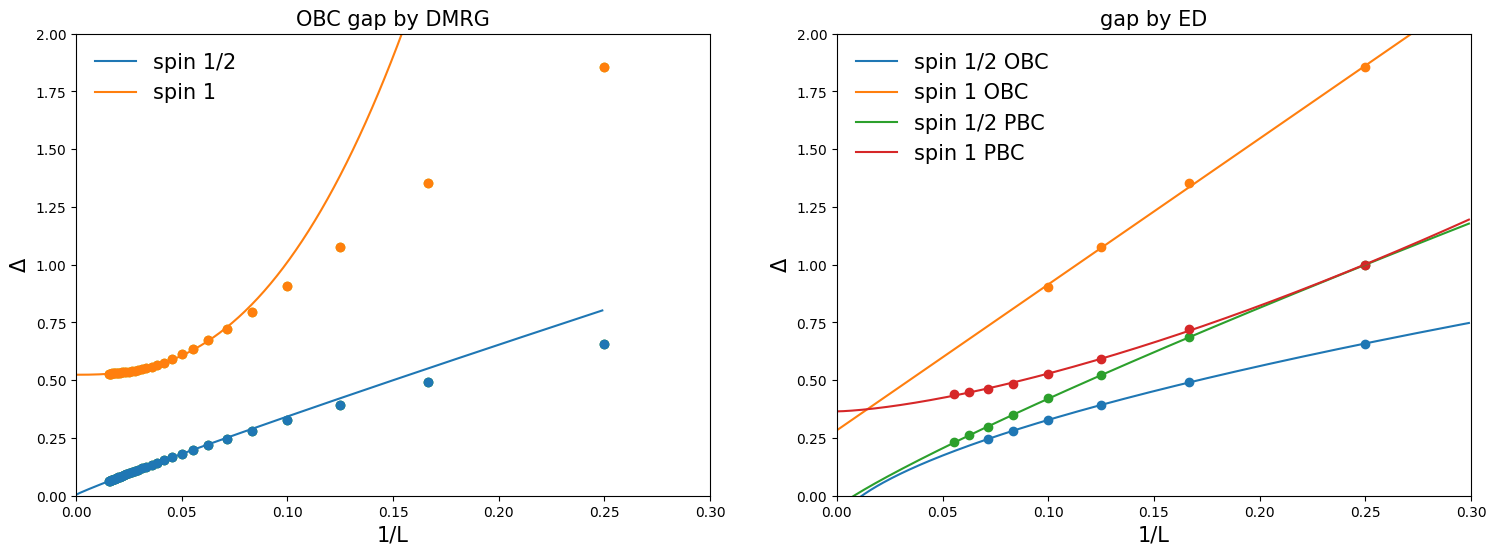

In [ ]:
fig=plt.figure(figsize=(18,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)


ax1.scatter(L_rev,gap_half_list,color="g")
ax1.scatter(L_rev,gap_one_list,color="y")


def func(x,a,b,c):
    return a*x**b+c
def func2(x,a,b,c):
    return a*x+c
def func3(x,a,b,c):
    return a*x**2+c

ax1.scatter(L_rev,gap_half_list)
ax1.scatter(L_rev,gap_one_list)

popt1,pcov1 = curve_fit(func,L_rev[10:],gap_half_list[10:])
x1 = np.arange(0,0.25,0.001)
y1 = [func(i,popt1[0],popt1[1],popt1[2]) for i in x1]
ax1.plot(x1,y1,label = "spin 1/2")

popt2,pcov2 = curve_fit(func,L_rev[10:],gap_one_list[10:])
x2 = np.arange(0,0.25,0.001)
y2 = [func(i,popt2[0],popt2[1],popt2[2]) for i in x2]
ax1.plot(x2,y2,label="spin 1")

ax1.set_xlim(0,0.3)
ax1.set_ylim(0,2)
ax1.legend(frameon=False,prop={"size":15})
ax1.set_title('OBC gap by DMRG',fontsize=15)
ax1.set_xlabel('1/L',fontsize=15)
ax1.set_ylabel("$\Delta$",fontsize=15)

xx1,yy1 = np.sort(1/np.arange(4,19,2)),np.array([0.232,0.261,0.298,0.348,0.423,0.523,0.685,1])
yy2 = np.array([0.44,0.45,0.46,0.4841964699122272,0.5248,0.5935,0.72062736262,1])
xx2 = np.array([1/14,1/12,1/10,1/8,1/6,1/4])
yy3 = np.array([0.2462320,0.280943,0.3273616,0.392692,0.49158177,0.65891862])
xx3 = np.array([1/10,1/8,1/6,1/4])
yy4 = np.array([0.903834024,1.075496161,1.35174157,1.85446346])
ax2.scatter(xx2,yy3)
ax2.scatter(xx3,yy4)
ax2.scatter(xx1,yy1)
ax2.scatter(xx1,yy2)


popt5,pcov5 = curve_fit(func,xx2,yy3)
xxx3 = np.arange(0,0.3,0.001)
yyy3 = [func(i,popt5[0],popt5[1],popt5[2]) for i in xxx3]
ax2.plot(xxx3,yyy3,label="spin 1/2 OBC")
ax2.set_xlim(0,0.3)
ax2.set_ylim(0,2)

popt6,pcov6 = curve_fit(func2,xx3,yy4)
xxx4 = np.arange(0,0.3,0.001)
yyy4 = [func(i,popt6[0],popt6[1],popt6[2]) for i in xxx4]
ax2.plot(xxx4,yyy4,label="spin 1 OBC")
ax2.set_xlim(0,0.3)
ax2.set_ylim(0,2)

popt3,pcov3 = curve_fit(func,xx1,yy1)
xxx1 = np.arange(0,0.3,0.001)
yyy1 = [func(i,popt3[0],popt3[1],popt3[2]) for i in xxx1]
ax2.plot(xxx1,yyy1,label="spin 1/2 PBC")

popt4,pcov4 = curve_fit(func,xx1,yy2)
xxx2 = np.arange(0,0.3,0.001)
yyy2 = [func(i,popt4[0],popt4[1],popt4[2]) for i in xxx2]
ax2.plot(xxx2,yyy2,label="spin 1 PBC")
ax2.set_xlim(0,0.3)
ax2.set_ylim(0,2)



ax2.legend(frameon=False,prop={"size":15})
ax2.set_title('gap by ED',fontsize=15)
ax2.set_xlabel('1/L',fontsize=15)
ax2.set_ylabel("$\Delta$",fontsize=15)

##txt="From Prof.Han-Qing Wu of SYSU"
##fig.text(0.8,0.005,txt,ha="right",fontsize=12)

As we can see, DMRG easily approch to large system sizes which are intractable for ED. The difference of the low lying gap between spin-1/2 and spin-1 can be clearly seen.

However, the $\Delta$ at L $\to$ ∞ obtained from our DMRG code is different from that of ED. This is due to the fact that we truncate the Hilbert space using the ground state density matrix and thus we discard some information of excited states. One can eliminate this issue by truncating the Hilbert space using not only the ground state density matrix but also those of first few excited states.